In [1]:
import os
import pandas as pd
import sleap
import numpy as np
import random
import re
import matplotlib.pyplot as plt

from pathlib import Path

# Step 1

This notebook processes labeled data to extract video age information and prepare datasets for model development. It outputs a CSV file summarizing video ages, a CSV detailing train-test splits, and a bar plot visualizing the age distribution.

### User-Defined Inputs
- **Labels Path**: Path to the input labeled data (`user_labels`), which must be specified before running the notebook.
- **Fractions for Data Splitting**:  
  - `fraction_train`: Proportion of data to be allocated to the training set.  
  - `val_test_fraction`: Proportion of the remaining data to be allocated to the test set.

### Key Functionalities
1. **Extracting Video Age Information**:  
   - Extracts the age (in days) from video filenames of labeled data.  
   - Saves the results to a CSV file (`video_ages.csv`).  
   - Generates a bar plot visualizing the age distribution.

2. **Splitting Data for Training**:  
   - Divides the labeled data into training, validation, and test sets using specified fractions.  
   - Repeats the split three times, saving datasets to directories (`train.pkg.slp`, `val.pkg.slp`, `test.pkg.slp`) with associated images.  
   - Records metadata for each split, including file path, version, labeled frames, and split type, in a CSV file (`train_test_splits_info.csv`).

### Outputs
- A CSV file (`video_ages.csv`) with video filenames and corresponding age information.  
- A CSV file (`train_test_splits_info.csv`) summarizing train-test splits.  
- A bar plot visualizing the age distribution.  

In [2]:
# labels path
labels_path = "D:/SLEAP/20250102_generalizability_experiment/primary/sorghum/labels_sorghum_5-12DAG_primary_6nodes.v008.slp"

# train, val and test fractions
fraction_train = 0.7 # fraction of total user labels to be used for training
val_test_fraction = 0.5 # 1-`fraction_train` allocated for validation and testing

# Directory output path
output_path = "D:/SLEAP/20250102_generalizability_experiment/primary/sorghum"

In [3]:
# Function to extract the age from the filename
def extract_age(filename):
    match = re.search(r'Day(\d+)_', filename)
    return match.group(1) if match else 'NA'

In [4]:
base_labels = sleap.load_file(Path(labels_path).as_posix()) # load labels file
user_labels = base_labels.with_user_labels_only() # user instances only

In [5]:
# Make the output directory if it doesn't exist
Path(output_path).mkdir(parents=True, exist_ok=True)

In [6]:
# Print the first few items to check their structure
for label in user_labels[:5]:
    print(label)

LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_sorghum/h5/W1/Day12_7-30-2024SlowScanner/VUC0VIWW2C.h5'), frame_idx=12, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_sorghum/h5/W1/Day12_7-30-2024SlowScanner/XROS01VRHZ.h5'), frame_idx=0, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_sorghum/h5/W1/Day12_7-30-2024SlowScanner/TATPMWUC5U.h5'), frame_idx=7, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_sorghum/h5/W1/Day12_7-30-2024SlowScanner/TATPMWUC5U.h5'), frame_idx=45, instances=1)
LabeledFrame(video=HDF5Video('D:/SLEAP/SLEAP_sorghum/h5/W1/Day12_7-30-2024FastScanner/3OP8BOG5AP.h5'), frame_idx=65, instances=1)


In [7]:
print(f"There are {len(user_labels)} labels total.")

# Variables to keep count of matches and non-matches
match_count = 0
no_match_count = 0

# Create a DataFrame from the user labels
data = []
for label in user_labels:
    age = extract_age(label.video.filename)
    if age != 'NA':
        match_count += 1
    else:
        no_match_count += 1
    data.append({'video_filename': label.video.filename, 'days_old': age})

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file = Path(output_path) / 'video_ages.csv'
df.to_csv(csv_file, index=False)

print(f"Details saved to {csv_file}")
print(f"Number of labeled frames with age found: {match_count}")
print(f"Number of labeled frames with age not found: {no_match_count}")


There are 300 labels total.
Details saved to D:\SLEAP\20250102_generalizability_experiment\primary\sorghum\video_ages.csv
Number of labeled frames with age found: 300
Number of labeled frames with age not found: 0


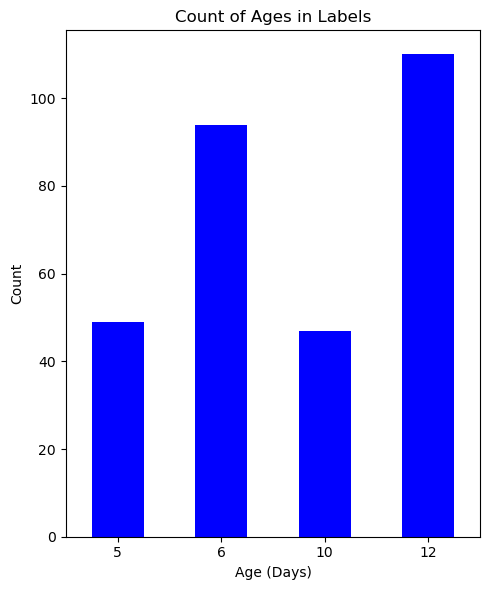

Plot saved to D:\SLEAP\20250102_generalizability_experiment\primary\sorghum\age_distribution.png


In [8]:
# Ensure the ages are treated as integers
df['days_old'] = df['days_old'].astype(int)

# Plotting the bar graph
age_counts = df['days_old'].value_counts().sort_index()
plt.figure(figsize=(5, 6), facecolor='white') 
age_counts.plot(kind='bar', color='blue')  # Set color to blue
plt.title('Count of Ages in Labels')
plt.xlabel('Age (Days)')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate the x-axis labels
plt.tight_layout()  # Adjusts the plot to ensure a tight fit

# Save the figure
plot_path = Path(output_path) / 'age_distribution.png'
plt.savefig(plot_path, facecolor='white', bbox_inches='tight')
plt.show()

print(f"Plot saved to {plot_path}")

In [9]:
n_train = int(fraction_train*len(user_labels))
print(f"Number of labels for training set should be {n_train}.")
n_val = int((1-fraction_train)*val_test_fraction*len(user_labels))
print(f"Number of labels for validation set should be {n_val}.")
n_test = int((1-fraction_train)*val_test_fraction*len(user_labels))
print(f"Number of labels for validation set should be {n_test}.")

Number of labels for training set should be 210.
Number of labels for validation set should be 45.
Number of labels for validation set should be 45.


In [10]:
# Initialize a list to store information for the CSV file
csv_data = []

for i in range(3):
    # Split the training and validation sets
    labels_train, _, labels_val, _ = sleap.nn.data.training.split_labels_train_val(user_labels, 1-fraction_train) # 1-`fraction_train` allocated for validation and testing
    labels_val, _, labels_test, _ = sleap.nn.data.training.split_labels_train_val(labels_val, val_test_fraction) # `val_test_fraction` of `labels_val` made into a test set

    # Make a directory for this split
    split_dir = Path(output_path) / f"train_test_split.v00{i}"
    os.makedirs(split_dir, exist_ok=True)

    # Save the train, val and test sets
    train_path = Path(split_dir) / "train.pkg.slp"
    val_path = Path(split_dir) / "val.pkg.slp"
    test_path = Path(split_dir) / "test.pkg.slp"
    labels_train.save(train_path, with_images=True)
    labels_val.save(val_path, with_images=True)
    labels_test.save(test_path, with_images=True)

    # Store the information in the list for train, val and test splits
    csv_data.append({'path': train_path, 'version': i, 'labeled_frames': len(labels_train), 'split_type': 'train'})
    csv_data.append({'path': val_path, 'version': i, 'labeled_frames': len(labels_val), 'split_type': 'val'})
    csv_data.append({'path': test_path, 'version': i, 'labeled_frames': len(labels_test), 'split_type': 'test'})

In [11]:
# Convert the list to a DataFrame and save as CSV
df = pd.DataFrame(csv_data)
csv_path = Path(output_path) / 'train_test_splits.csv'
df.to_csv(csv_path, index=False)

print(f"Train, val and test splits information saved to {csv_path}")

Train, val and test splits information saved to D:\SLEAP\20250102_generalizability_experiment\primary\sorghum\train_test_splits.csv


In [12]:
df

,path,version,labeled_frames,split_type
0,D:\SLEAP\20250102_generalizability_experiment\...,0,210,train
1,D:\SLEAP\20250102_generalizability_experiment\...,0,45,val
2,D:\SLEAP\20250102_generalizability_experiment\...,0,45,test
3,D:\SLEAP\20250102_generalizability_experiment\...,1,210,train
4,D:\SLEAP\20250102_generalizability_experiment\...,1,45,val
5,D:\SLEAP\20250102_generalizability_experiment\...,1,45,test
6,D:\SLEAP\20250102_generalizability_experiment\...,2,210,train
7,D:\SLEAP\20250102_generalizability_experiment\...,2,45,val
8,D:\SLEAP\20250102_generalizability_experiment\...,2,45,test
